# CS 505 Homework 04:  Classification

#### Due Friday  10/27 at midnight (1 minute after 11:59 pm) in Gradescope (with a grace period of 6 hours)
#### You may submit the homework up to 24 hours late (with the same grace period) for a penalty of 10%.

All homeworks will be scored with a maximum of 100 points; point values are given
for individual problems, and if parts of problems do not have point values given, they
will be counted equally toward the total for that problem.

Note: I strongly recommend you work in **Google Colab** (the free version) to complete homeworks in this class; in addition to (probably) being faster than your laptop, all the necessary libraries will already be available to you, and you don't have to hassle with <code>conda</code>, <code>pip</code>, etc. and resolving problems when the install doesn't work. But it is up to you!   You should go through the necessary tutorials listed on the web site concerning Colab and storing files on a Google Drive. And of course, Dr. Google is always ready to help you resolve your problems.

I will post a  "walk-through" video ASAP on my <a href="https://www.youtube.com/channel/UCfSqNB0yh99yuG4p4nzjPOA">Youtube Channel</a>.

#### Submission Instructions

You must complete the homework by editing <b>this notebook</b> and submitting the following two files in Gradescope by the due date and time:

  - A file <code>HW04.ipynb</code> (be sure to select <code>Kernel -> Restart and Run All</code> before you submit, to make sure everything works); and
  - A file <code>HW04.pdf</code> created from the previous.
  
  For best results obtaining a clean PDF file on the Mac, select <code>File -> Print Review</code> from the Jupyter window, then choose <code>File-> Print</code> in your browser and then <code>Save as PDF</code>.  Something  similar should be possible on a Windows machine -- just make sure it is readable and no cell contents have been cut off. Make it easy to grade!
  
The date and time of your submission is the last file you submitted, so if your IPYNB file is submitted on time, but your PDF is late, then your submission is late.

## Collaborators (5 pts)

Describe briefly but precisely

1. Any persons you discussed this homework with and the nature of the discussion;
2. Any online resources you consulted and what information you got from those resources; and
3. Any AI agents (such as chatGPT or CoPilot) or other applications you used to complete the homework, and the nature of the help you received.

A few brief sentences is all that I am looking for here.

    This problem set was definitely time consuming. I went to Officer Hours
    to ask for help as well as utilizing GeeksforGeeks to look at how we can manipulate strings and tokenize them into a list. I used a lot of the online links provided in the homework below help plot the datasets into graphs. I also had to reach out to ChatGpt on how we can save the word vectors from our spam dataset because it was going to 25-30 min to run it everytime so I asked chatgpt on how we can save the output to our drive and then load the word vectors back up to be trained on.

In [ ]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

from torchvision.datasets import MNIST
import torchvision.transforms as T

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


## Problem One: Exploring Shakespeare's Plays with PCA (45 pts)

In this problem, we will use Principal Components Analysis to look at Shakespeare's plays, as
we discussed with a very different play/movie in lecture.  Along the way, we shall use the tokenizer and the TF-IDF vectorizer from `sklearn,`
a common machine learning library.

Note: There is a library for text analysis in Pytorch called `Torchtext`, however, in my view this will less well-developed and less well-supported than the rest of Pytorch, so we shall use `sklearn` for this problem.



### Part A:  Reading and exploring the data (5 pts)

The cells below read in three files and convert them to `numpy` arrays (I prefer to work with the arrays rather than with `pandas` functions, but it is your choice).  

1. The file `shakespeare_plays.csv` contains lines from William Shakespeare’s plays. The second column of the file contains the name of
the play, the third the name of the player (or the indication `<Stage Direction>`, and the fourth
the line spoken:




2. The file `play_attributes.csv` stores the genres and chronology of Shakepeare's plays; the first column is the name of the play, the second the genre, and the third its order in a chronological listing of when it was first performed. The plays are in the same (arbitrary) order as in the first file.



3. The file `player_genders.csv` stores the name of a major character (defined somewhat arbitrarily as one whose total lines contain more than 1400 characters) in the first column and their gender in the second.



**To Do:**   For each of the arrays, print out the the `shape` and the first line.


In [ ]:
plays_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/shakespeare_plays.csv').to_numpy()
print(f'shape is {plays_array.shape}, rows: {plays_array.shape[0]}, columns: {plays_array.shape[1]}')
print(f'The first line: {plays_array[0]}')
player_genders_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/player_genders.csv').to_numpy()
print(f'shape is {player_genders_array.shape}, rows: {player_genders_array.shape[0]}, columns: {player_genders_array.shape[1]}')
print(f'The first line: {player_genders_array[0]}')

play_attributes_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/play_attributes.csv').to_numpy()
print(f'shape is {play_attributes_array.shape}, rows: {play_attributes_array.shape[0]}, columns: {play_attributes_array.shape[1]}')
print(f'The first line: {play_attributes_array[0]}')



shape is (111582, 4), rows: 111582, columns: 4
The first line: [1 'Henry IV Part 1' '<Stage Direction>' 'ACT I']
shape is (398, 2), rows: 398, columns: 2
The first line: ['AARON' 'male']
shape is (36, 3), rows: 36, columns: 3
The first line: ['Henry IV Part 1' 'History' 15]


### Part B: Visualizing the Plays (8 pts)

1. Create an array containing 36 strings, each being the concatenation of all lines spoken.   Be sure to NOT include stage directions!  You may wish to create an appropriate dictionary as an intermediate step.

2. Create a document-term matrix where each row represents a play and each column represents a term used in that play. Each entry in this matrix represents the number of times a particular word (defined by the column) occurs in a particular play (defined by the row). Use `CountVectorizer` in `sklearn` to create the matrix. Keep the rows in the same order as in the original files in order to associate play names with terms correctly.

3. From this matrix, use `TruncatedSVD` in `sklearn` to create a 2-dimensional representation of each play. Try to make it as similar as possible to the illustration below, including (i) appropriate title, (ii) names of each play, followed by its chronological order, and (iii) different colors for each genre. Use a `figsize` of `(8,8)` and a `fontsize` of `6` to provide the best visibility. You can follow the tutorial [here](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/) to create the visualization (look at the "PCA" part).

4. Now do the same thing all over again, but with TF-IDF counts (using `TFIDFVectorizer` in `sklearn`).


5. Answer the following in a few sentences:  What plays are similar to each other? Do they match the grouping of Shakespeare’s plays into comedies, histories, and tragedies here?  Which plays are outliers (separated from the others in the same genre)?  Did one of TF or TF-IDF provided the best insights?


In [ ]:
#Part B no 1
play_lines = defaultdict(lambda: ' ')
lines = ""
for i in range(len(play_attributes_array)):
  name = play_attributes_array[i][0]
  for (n,play,player,line) in plays_array:
    if player  == '<Stage Direction>':
      continue
    if play == play_attributes_array[i][0]:
      lines += " ".join(line.split())
      lines += " "

  play_lines[name] = lines
  lines = ""
play_names = list(play_lines.keys())
play_strings_array = list(play_lines.values())

In [ ]:
#Part B no 2 CountVectorizer
#Create a vectorizer object
vectorizer = CountVectorizer()
#Create a document term matrix from the list of each plays
document_term_matrix = vectorizer.fit_transform(play_strings_array)
pca = TruncatedSVD(n_components=2)
result = pca.fit_transform(document_term_matrix)

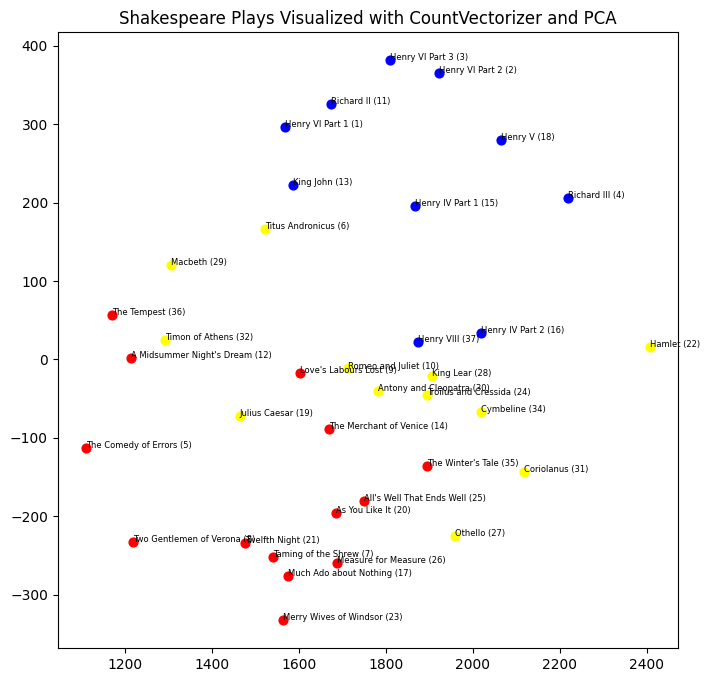

In [ ]:
#Part B no3
plt.figure(figsize=(8,8))
for i in range(len(play_attributes_array)):
  x,y = result[i]
  play = play_attributes_array[i][0]
  genre = play_attributes_array[i][1]
  time = play_attributes_array[i][2]
  color = 'blue' if genre == "History" else 'red' if genre == "Comedy" else 'yellow'
  label = f"{play} ({time})"
  plt.scatter(x,y,c=color,s=40)
  plt.annotate(label,(x,y),fontsize=6)
plt.title("Shakespeare Plays Visualized with CountVectorizer and PCA")
plt.show()

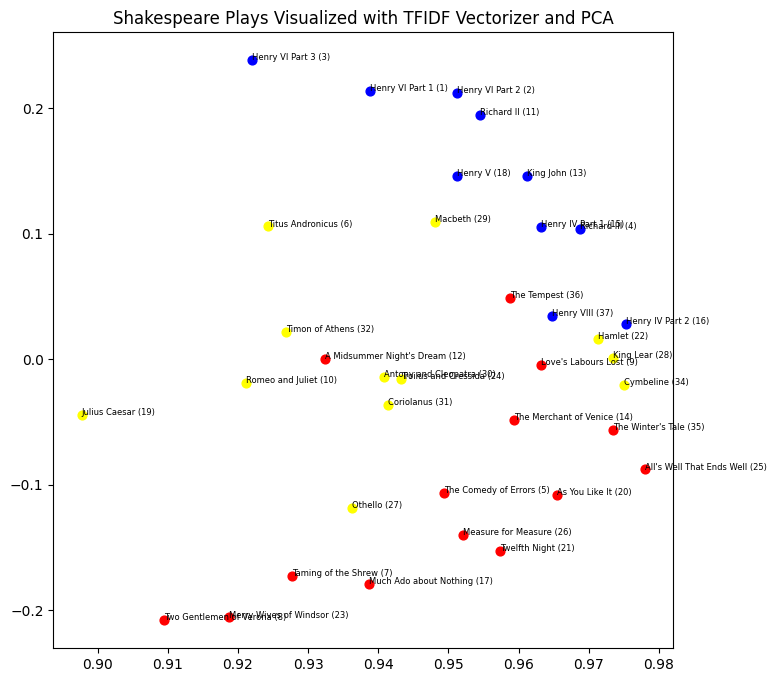

In [ ]:
#Part B no4 using TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(play_strings_array)
pca = TruncatedSVD(n_components=2)
result2 = pca.fit_transform(tfidf_matrix)
plt.figure(figsize=(8,8))
for i in range(len(play_attributes_array)):
  x,y = result2[i]
  play = play_attributes_array[i][0]
  genre = play_attributes_array[i][1]
  time = play_attributes_array[i][2]
  color = 'blue' if genre == "History" else 'red' if genre == "Comedy" else 'yellow'
  label = f"{play} ({time})"
  plt.scatter(x,y,c=color,s=40)
  plt.annotate(label,(x,y),fontsize=6)
plt.title("Shakespeare Plays Visualized with TFIDF Vectorizer and PCA")
plt.show()

**Part B no5 Anaylsis**

The plays that I see from the graph that are the most similar seems to be the plays that have the same genres with one another. The grouping matches pretty well to Shakespeares genre of plays separted by Comedy, Tragedy, and History as we can see history plays are matched on top of the y axis, comedy in the bottom, and tragedy is around the middle of the pact. In this case, it seems that Hamlet is an outlier. The TFIDF provided better insights because it shows better spacing. But I'm confused on how Hamlet with CountVectorizer is very far off from other tragedy plays whereas Julius Caesar with TFIDF vectorizer is further off from other tragedies.

### Part C: Visualizing the Players (8 pts)

Now you must repeat this same kind of visualization, but instead of visualizing plays, you must visualize players.
The process will be essentially the same, starting with an array of strings representing the lines spoken by each player. Use one of TF or TF-IDF, and use different colors for the genders.

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible.

Again, comment on what you observe (it will not be as satisfying as the previous part).

In [ ]:
#Visualizing the players
player_lines = defaultdict(lambda: ' ')
lines = ""
for (player1,gender) in player_genders_array:
  for (_,play,player,line) in plays_array:
    if player1 == player:
      lines += " ".join(line.split())
      lines += " "
  player_lines[player1] = lines
  lines = ""

In [ ]:
#Using CountVectorizer for each player
player_array = list(player_lines.keys())
player_strings_array = list(player_lines.values())
vectorizer = CountVectorizer()
#Create a document term matrix from the list of each plays
document_term_matrix = vectorizer.fit_transform(player_strings_array)
pca = TruncatedSVD(n_components=2)
result = pca.fit_transform(document_term_matrix)

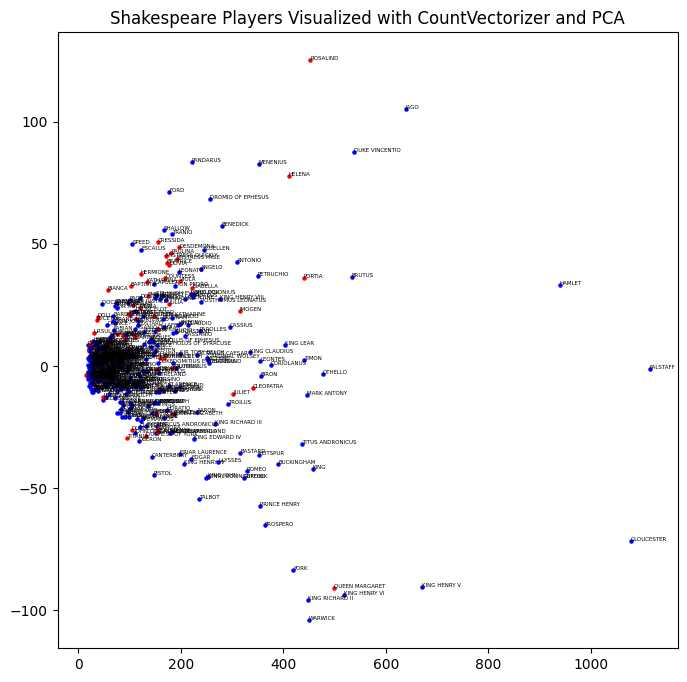

In [ ]:
#Plotting the play
plt.figure(figsize=(8,8))
for i in range(len(player_genders_array)):
  x,y = result[i]
  name = player_genders_array[i][0]
  gender = player_genders_array[i][1]
  color = 'blue' if gender == "male" else 'red'
  label = f"{name}"
  plt.scatter(x,y,c=color,s=5)
  plt.annotate(label,(x,y),fontsize=4)
plt.title("Shakespeare Players Visualized with CountVectorizer and PCA")
plt.show()

**Anaylsis**

The outliers that I from this graph could maybe be because the characters didn't recieve enough lines to speak during the play. Whereas the cluster of names towards the y axis could mean that these speakers had more lines spoken in a play which is why they're all clustered up together. The character relations in this case would be the number of lines that they spoked during the plays which meant that they must be important characters to the play because main characters would often have the most lines spoken given their importance.

### Part D:  DIY Word Embeddings (8 pts)

In this part you will create a word-word matrix where each row (and each column) represents a word in the vocabulary.
Each entry in this matrix represents the number of times a particular word (defined by the row) co-occurs with another
word (defined by the column) in a sentence (i.e., line in `plays`). Using the row word vectors, create a document-term matrix which represents
a play as the average of all the word vectors in the play.

Display the plays using `TruncatedSVD` as you did previously.  

Again, comment on what you observe: how different is this from the first visualization?

**Notes:**  

1. Remove punctuation marks .  ,  ;  :  ?  ! but leave single quotes.
2. One way to proceed is to create a nested dictionary mapping each word to a dictionary of the frequency of words that occur in the same line, then from this to create the sparse matrix which is used to create the aerage document-term matrix which is input to `TruncatedSVD`.
3. If you have trouble with the amount of memory necessary, you may wish to eliminate "stop words" and then isolate some number (say, 5000) of the remaining most common words, and build your visualization on that instead of the complete vocabulary.


**Note**

For 1D, I used all the words in all of Shakespeare's play and got rid of all the punctuations except for apostrophes. I got around 29,000 words after processing each word to lower case and then split the sentences into a list of individual words to process.

In [ ]:
#Every sentence in all the plays
V = [ln[3] for ln in plays_array if ln[2] != '<Stage Direction>']


In [ ]:
# nested_hashtable = defaultdict(lambda: defaultdict(int))
nested_hashtable = defaultdict(lambda: defaultdict(lambda: 0))
#A helper function to help processed the text to remove any puncuation marks
def remove_punctuation(text):
  text = text.lower()
  text = re.sub(r'[.,;:?!]', '',text)
  text = re.sub(r'--', '',text)
  text = re.sub(r'-','',text)
  return text
#V = list of all sentences
#Were creating a sparse matrix
for line in V:
  #Preprocess the each sentence
  line = remove_punctuation(line)
  line = line.split()
  #Iterate through each sentence
  for i in range(len(line)):
    #Iterate through the same sentence but starting off from indice i
    for j in range(len(line)):
      word_1 = line[i]
      word_2 = line[j]
      if i == j:
        continue
      nested_hashtable[word_1][word_2] += 1


In [ ]:
#Create a list from all the keys representing all the unique words in all the plays
words = nested_hashtable.keys()
#The length of the words list will be use for our N x N matrix
N = len(words)
#Create dictionary comprehension to keep a ordered indice of each unique word that occurs in all the plays
index_d = {word: i for i, word in enumerate(words)}
#Create a N x N cooccurence matrix
co_occurence_matrix = np.zeros((N,N))
#Get the word and it's co-occuring words from the nested dictionary
for word_1, co_occurence in nested_hashtable.items():
  #get the index of the word in order to place the word in the correct row
  i = index_d[word_1]
  #Now we iterate through the inner dictionary and get the co-occuring words and the number of times each co-occuring occurs with word_1
  for word_2, count in co_occurence.items():
    #Get the index of the co-occuring word representing the column to put the count in
    j = index_d[word_2]
    #Put the count of one word and it's co-occuring words
    co_occurence_matrix[i][j] = count


In [ ]:
#Create a word to vector to get the row vector for each word given the indice
word_to_vector ={}
for word,index in index_d.items():
  word_to_vector[word] = co_occurence_matrix[index]


In [ ]:
play_vectors = {}
#Preprocess the text
play_text = [remove_punctuation(play) for play in play_strings_array]
play_text = [line.lower().split() for line in play_text]
#A for loop to get the indice and the play name
for index, play in enumerate(play_text):
  #Create a row N of a zero vector
  word_vectors = np.zeros(N)
  #Get the play name
  plays = play_names[index]
  #Now we iterate each word in each play
  for word in play:
    #If the word is currently not in our co occurence matrix, we add a vector with N zeros
    if word not in word_to_vector.keys():
      word_vectors += np.zeros(N)
    else:
      #We add each row vector of the word and the counts that co occurs with other words in the row
      word_vectors += np.array(word_to_vector[word])
  #Divide the word vector by the length of the play to get the mean_vector
  word_vectors /= len(play)
  #Store that mean vector in a dictionary with the corresponding key play
  play_vectors[plays] = word_vectors
#Get the vectors for each play
document_term_matrix1 = list(play_vectors.values())


In [ ]:
svd = TruncatedSVD(n_components=2)
plays_svd = svd.fit_transform(document_term_matrix1)

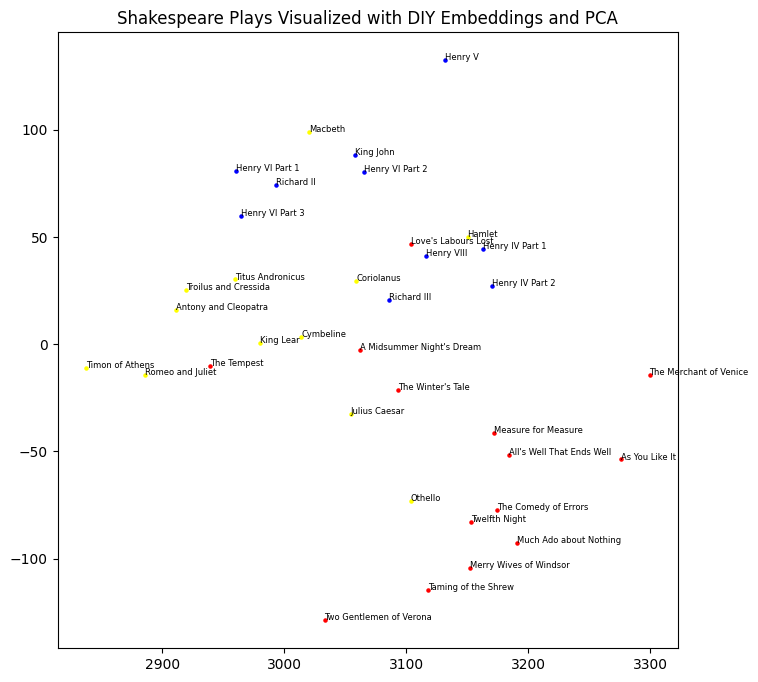

In [ ]:
#Part B no3
plt.figure(figsize=(8,8))
for i,play_name in enumerate(play_names):
  x,y = plays_svd[i]
  genre = play_attributes_array[i][1]
  color = 'blue' if genre == "History" else 'red' if genre == "Comedy" else 'yellow'
  label = play_name
  plt.scatter(x,y,c=color,s=5)
  plt.annotate(label,(x,y),fontsize=6)
plt.title("Shakespeare Plays Visualized with DIY Embeddings and PCA")
plt.show()

**Anaylsis**

From the first visualization, we can the groupings of each genre is more distinc from each other. Like with the outliers, we can see outliers are more grouped together in the corresponding of their sides with exception of Hamlet, Macbeth, The Tempest being out of place with their groupings of outliers. The outliers might occur because some words could've been used more often in one genre of a play but then a different type of play genre also used the same kind of words which could be why it's grouped this way.

### Part E:  Visualizing the Plays using Word2Vec Word Embeddings (8 pts)

Now we will do the play visualization using word embeddings created by Gensim's `Word2Vec`, which can create word embeddings just as you did in the previous part, but using better algorithms.

You can read about how to use `Word2Vec` and get template code here:

https://radimrehurek.com/gensim/models/word2vec.html

I strongly recommend you follow the directions for creating the model, then using `KeyedVectors` to
avoid recomputing the model each time.

Experiment with the `window` (say 5) and the `min_count` (try in the range 1 - 5) parameters to get the best results.

Display the plays using `PCA` instead of `TruncatedSVD`.  

Again, comment on what you observe: how different is this from the other visualizations?


In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
#Tokenize our text for each play
play_text = [remove_punctuation(play) for play in play_strings_array]
play_text = [line.lower().split() for line in play_text]
#Train our Word2Vec model
play_model = Word2Vec(sentences=play_text,window=5,min_count=1)
#We will create another document term matrix with dimensions of 36 by the model.vector_size of 100
play_vectors = []
#Create a for loop to iterate through all the lines in each play
for i,line in enumerate(play_text):
  #Initialize a vector of size 100
  mean_vector = np.zeros(play_model.vector_size)
  #For each word in the line
  #Add each word vector to the mean_vector array
  for word in line:
    try:
      mean_vector += play_model.wv[word]
    #If theres an error, we skip the word and continue with the next
    except KeyError:
      continue
  #Divide the vector by the length of a play
  mean_vector /= len(line)
  #Add the mean_vector to our document term matrix
  play_vectors.append(mean_vector)


In [ ]:
pca = PCA(n_components=2)
result3 = pca.fit_transform(play_vectors)

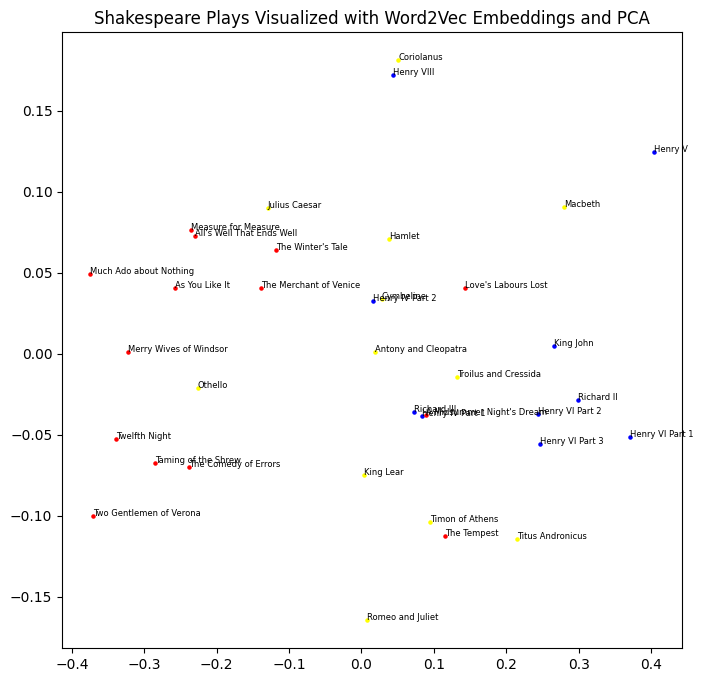

In [ ]:
plt.figure(figsize=(8,8))
for i in range(len(play_attributes_array)):
  x,y = result3[i]
  play = play_attributes_array[i][0]
  genre = play_attributes_array[i][1]
  color = 'blue' if genre == "History" else 'red' if genre == "Comedy" else 'yellow'
  label = f"{play}"
  plt.scatter(x,y,c=color,s=5)
  plt.annotate(label,(x,y),fontsize=6)
plt.title("Shakespeare Plays Visualized with Word2Vec Embeddings and PCA")
plt.show()

**Anaylsis**

This is different from the other visualizations as we are able to see more outliers from each play. But now, we are able to see more of the same genre plays being grouped together more closely with one another. We see Comedy plays are group more towards the left side of the graph whereas the history plays are group more towards the right side of the graph. Tragedy plays are sort of in the middle and we do see the most outliers from tragedy plays like Romeo and Juliet all the way at the bottom.

### Part F:  Visualizing the Players using Word2Vec Word Embeddings (8 pts)

Now you must repeat Part C, but using these `Word2Vec` embeddings.

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible.

Again, comment on what you observe. How is this different from what you saw in Part C?


In [ ]:
#Same process as 1E but we do it for the players this time
player_text = [remove_punctuation(line) for line in player_strings_array]
player_text = [line.lower().split() for line in player_text]
player_model = Word2Vec(sentences=player_text,window=5,min_count=1)
player_word_vectors = []

for i,line in enumerate(player_text):
   #Remove all the punctuations for each word and replace it with ''
  mean_vector = np.zeros(player_model.vector_size)
  for word in line:
    try:
      mean_vector += player_model.wv[word]
    except KeyError:
      continue
  mean_vector /= len(line)
  player_word_vectors.append(mean_vector)

In [ ]:
pca = PCA(n_components=2)
result4 = pca.fit_transform(player_word_vectors)

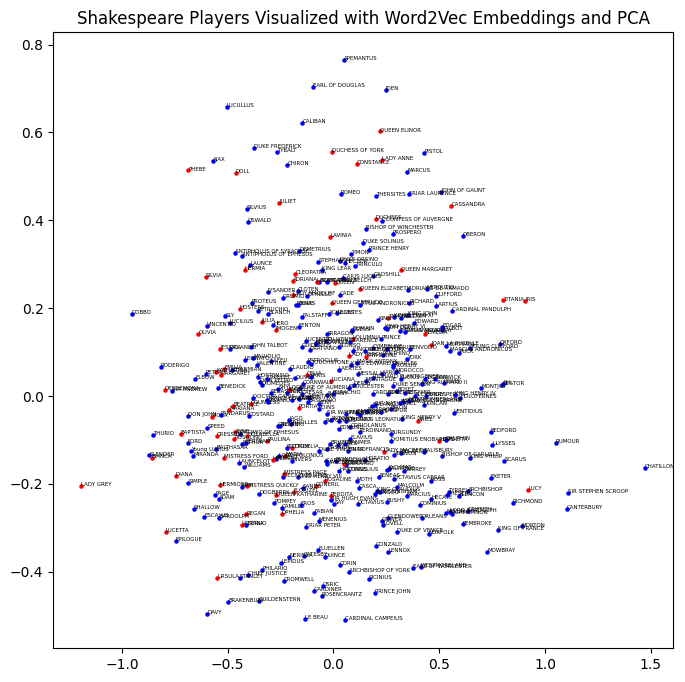

In [ ]:
plt.figure(figsize=(8,8))
for i in range(len(player_genders_array)):
  x,y = result4[i]
  name = player_genders_array[i][0]
  gender = player_genders_array[i][1]
  color = 'blue' if gender == "male" else 'red'
  label = f"{name}"
  plt.scatter(x,y,c=color,s=5)
  plt.annotate(label,(x,y),fontsize=4)
plt.title("Shakespeare Players Visualized with Word2Vec Embeddings and PCA")
plt.show()

**Anaylsis**

From Part C, we could see a lot of the characters being more compacted together and less scattered. But in 1F, we can that all the characters are more evenly scattered around the middle of the graph. I think in this case, the character distribution is definitely more fair which could mean that characters in the middle are more of the main characters in the play. Whereas outside of the middle would represent supporting characters.

## Problem Two: Classifying Text with a Feed-Forward Neural Network (50 pts)


In this problem, you must create a FFNN in Pytorch to classify emails from the Enron dataset as to whether they
are spam or not spam ("ham"). For this problem, we will use `Glove` pretrained embeddings. The dataset
and the embeddings are in the following location:

https://drive.google.com/drive/folders/1cHR4VJuuN2tEpSkT3bOaGkOJrvIV-lSR?usp=sharing

(You can also download the embeddings yourself from the web; but the dataset is one created
just for this problem.)

### Part A: Prepare the Data (10 pts)

Compute the features of the emails (the vector of 100 floats input to the NN) vector based on the average value of the word vectors that belong to the words in it.

Just like the previous problem, we compute the 'representation' of each message, i.e. the vector, by averaging word vectors; but this time, we are using [Glove word embeddings](https://nlp.stanford.edu/projects/glove/) instead. Specifically, we are using word embedding 'glove.6B.100d' to obtain word vectors of each message, as long as the word is in the 'glove.6B.100d' embedding space.

Here are the steps to follow:

1. Have a [basic idea](https://nlp.stanford.edu/pubs/glove.pdf) of how Glove provides pre-trained word embeddings (vectors).
2. Download and extract word vectors from 'glove.6B.100d'.
3. Tokenize the messages ( `spacy` is a good choice) and compute the message vectors by averaging the vectors of words in the message. You will need to test if a word is in the model (e.g., something like ` if str(word) in glove_model ...`) and ignore any words which have no embeddings.


### Part B: Create the DataLoader (15 pts)

Now you must separate the data set into training, validation, and testing sets, and build a 'Dataset' and 'DataLoader' for each that can feed data to train your model with Pytorch.

Use a train-validation-test split of 80%-10%-10%. You can experiment with different batch sizes, starting with 64.



Hints:
1. Make sure `__init__` , `__len__` and `__getitem__` of the your defined dataset are implemented properly. In particular, the `__getitem__` should return the specified message vector and its label.
2. Don't compute the message vector when calling the `__getitem__` function, otherwise the training process will slow down A LOT. Calculate these in an array before creating the data loader in the next step.
3. The data in the `.csv` is randomized, so you don't need to shuffle when doing the split.

In [ ]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import spacy
from google.colab import drive
drive.mount('/content/drive')
data_dir  = 'https://drive.google.com/drive/folders/1cHR4VJuuN2tEpSkT3bOaGkOJrvIV-lSR?usp=share_link'
file_path = '/content/drive/My Drive/glove.6B/glove.6B.100d.txt'

import torch

import torch.nn.functional as F
from torch.utils.data import random_split,Dataset, DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

import matplotlib.pyplot as plt
nlp = spacy.load('en_core_web_sm')

In [3]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '/content/drive/My Drive/glove.6B/glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

<ipython-input-3-895d63647745>:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 100)

In [4]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [5]:
emails_raw = pd.read_csv('/content/drive/My Drive/data_pa5/enron_spam_ham.csv').to_numpy()

In [6]:
def vector_emails(emails,model):
  tokens = nlp(emails)
  vectors = np.zeros(100)
  counter = 0
  for word in tokens:
    if str(word) in model:
      vectors += model[str(word)]
      counter += 1
  if counter > 0:
    vectors /= counter
  return vectors

In [7]:
message_vectors = []
for email, i in tqdm(emails_raw):
  vector = vector_emails(email,model)
  message_vectors.append(vector)
message_vectors = np.array(message_vectors)

100%|██████████| 28138/28138 [26:54<00:00, 17.43it/s]


In [8]:
#Save our word2vec data in a npy file in our drive
vector_path = "/content/drive/My Drive/message_vectors_final.npy"
# Save message_vectors to the file
np.save(vector_path, message_vectors)

In [9]:
message_vectors = np.load(vector_path)

In [11]:
#Create a list of labels for each email with labels either 1 indicating spam or 0 not spam
labels = [emails_raw[i][1] for i in range(len(emails_raw))]
X_email = torch.tensor(message_vectors).float()
Y_email = torch.tensor(labels).long()

In [12]:
# divide into training, validation, and testing data sets
def separate_data(X,Y,percent_validation=0.1,percent_test=0.1):

    N = len(X)
    len_validation = int(percent_validation*N)
    len_test = int(percent_test*N)
    len_train = N - len_validation - len_test

    len_t_v = len_train+len_validation

    X_train      = X[:len_train]
    Y_train      = Y[:len_train]
    X_validation = X[len_train:len_t_v]
    Y_validation = Y[len_train:len_t_v]
    X_test = X[len_t_v:]
    Y_test = Y[len_t_v:]

    return (X_train,Y_train,X_validation,Y_validation,X_test,Y_test)

In [13]:
X_train_set, Y_train_set, X_val_set, Y_val_set, X_test_set, Y_test_set = separate_data(X_email,Y_email)
N_train, N_val, N_test = len(X_train_set), len(X_val_set), len(X_test_set)

In [14]:
#Part B Creating the DataLoader
class EmailDataset(Dataset):
  def __init__(self,X,Y):
    self.X = X
    self.Y = Y
  def __len__(self):
      return len(self.X)
  def __getitem__(self,idx):
    #Return the email vector and label to the corresponding indice
      return self.X[idx],self.Y[idx]

In [15]:
batch_size = 128

training_ds = EmailDataset(X_train_set, Y_train_set)

validation_ds = EmailDataset(X_val_set, Y_val_set)

testing_ds = EmailDataset(X_test_set, Y_test_set)

training_dataloader   = DataLoader(training_ds, batch_size=batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_ds,   batch_size=batch_size, shuffle=False)
testing_dataloader    = DataLoader(testing_ds ,  batch_size=batch_size, shuffle=False)

### Part C:  Build the neural net model (25 pts)

Once the data is ready, we need to design and implement our neural network model.

The model does not need to be complicated. An example structure could be:

1. linear layer 100 x 15
2. ReLU activation layer
3. linear layer 15 x 2

But feel free to test out other possible combinations of linear layers & activation function and whether they make significant difference to the model performance later.

In order to perform "early stopping," you must keep track of the best validation score as you go through the epochs, and
save the best model generated so far; then use the model which existed when the validation score
was at a minimum to do the testing. (This could also be the model which is deployed, although we won't
worry about that.) Read about `torch.save(...)` and `torch.load(...)` to do this.

Experiment with different batch sizes and optimizers and learning rates to get the best validation
score for the model you create with early stopping. (Try not to look *too hard* at the final accuracy!) Include your final performance charts (using `show_performance_curves`) when you submit.

Conclude with a brief analysis (a couple of sentences is fine) relating what experiments you did,
and what choices of geometry, optimizer, learning rate, and batch size gave you the best results.
It should not be hard to get well above 90% accuracy on the final test.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


In [17]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss,label='Training',color='g')
    plt.plot(validation_loss,label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
#     plt.ylim(-0.1,(max(max(training_loss),max(validation_loss))*1.1) )
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print('Final Training Loss:  ',np.around(training_loss[-1],6))
    print('Final Validation Loss:',np.around(validation_loss[-1],6))

    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy,label='Training',color='g')
    plt.plot(validation_accuracy,label='Validation',color='b')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
#     plt.ylim(-0.1,1.1)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print('Final Training Accuracy:  ',np.around(training_accuracy[-1],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[-1],6))
    print()

    print("Test Accuracy:", test_accuracy.item())
    print()

In [18]:
#Build a Feed Forward Network
class FFNN(nn.Module):
  def __init__(self,input_size=100,hidden_size=15,labels=2):
        super(FFNN,self).__init__()
        self.linear_layer1 = nn.Linear(input_size,hidden_size)
        self.activation = nn.ReLU()
        self.linear_layer2 = nn.Linear(hidden_size,labels)

  def forward(self, x):
      x = self.linear_layer1(x)
      #x= F.sigmoid(x)
      x = self.activation(x)
      x= self.linear_layer2(x)
      return x

In [27]:
mail_model = FFNN().to(device)
num_epochs = 0

100%|██████████| 200/200 [01:45<00:00,  1.90it/s]


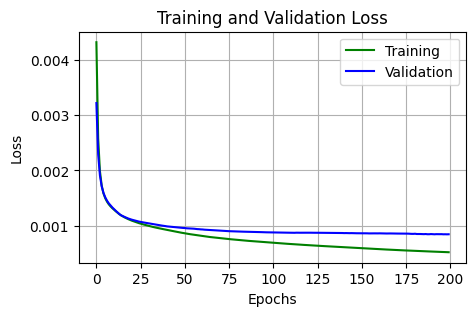

Final Training Loss:   0.000522
Final Validation Loss: 0.000847


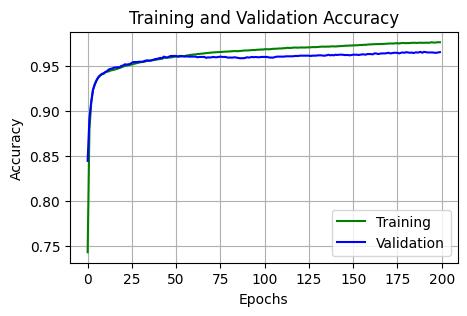

Final Training Accuracy:   0.976546
Final Validation Accuracy: 0.965517

Test Accuracy: 0.9658727049827576



In [28]:
num_epochs = 200
loss_fn = nn.CrossEntropyLoss()
#SGD gave a 89% test accuracy and 0.002 loss in validation
#optimizer = optim.SGD(mail_model.parameters(),lr=0.001)

#Adam gave the best results of a 96% test accuracy and 0.0008 loss in validation
optimizer = optim.Adam(mail_model.parameters(),lr=0.001)

#Adagrad gave the result with a 94% test accuracy and 0.001 loss in validation
#optimizer = optim.Adagrad(mail_model.parameters(),lr=0.01)

#RMSprop gave the second best results with a 95.9% test accuracy and 0.0009 loss in validation
#optimizer = optim.RMSprop(mail_model.parameters(),lr=0.001)

batch_size    = 128
training_loss = np.zeros(num_epochs)
val_loss      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

for epoch in tqdm(range(num_epochs)):
  mail_model.train()
  t_loss = 0.0
  t_num_correct = 0

  for X_train_batch, Y_train_batch in training_dataloader:
    X_train_batch = X_train_batch.to(device)
    Y_train_batch = Y_train_batch.to(device)

    optimizer.zero_grad()
    Y_train_hat = mail_model(X_train_batch)
    loss = loss_fn(Y_train_hat, Y_train_batch)
    loss.backward()
    optimizer.step()
    t_loss += loss.item()

    t_num_correct += (torch.argmax(Y_train_hat,dim=1) == Y_train_batch).float().sum()

  training_loss[epoch]   = t_loss/N_train
  training_accuracy[epoch] = t_num_correct/N_train

  #Validation
  v_loss = 0.0
  mail_model.eval()
  v_num_correct = 0

  for X_val_batch,Y_val_batch in validation_dataloader:
    X_val_batch  = X_val_batch.to(device)
    Y_val_batch  = Y_val_batch.to(device)

    Y_hat_val = mail_model(X_val_batch)
    loss = loss_fn(Y_hat_val, Y_val_batch)
    v_loss += loss.item()

    v_num_correct += (torch.argmax(Y_hat_val,dim=1) == Y_val_batch).float().sum()

  val_loss[epoch] = v_loss/N_val
  val_accuracy[epoch] = v_num_correct/N_val

#Testing
num_correct_test = 0
mail_model.eval()

for X_test_batch, Y_test_batch in testing_dataloader:
  X_test_batch = X_test_batch.to(device)
  Y_test_batch = Y_test_batch.to(device)

  Y_hat_test = mail_model(X_test_batch)

  num_correct_test += (torch.argmax(Y_hat_test,dim=1) == Y_test_batch).float().sum()
  test_accuracy = num_correct_test / N_test

show_performance_curves(training_loss,val_loss,training_accuracy,val_accuracy,test_accuracy)

**Anaylsis**

For training the model, I basically follow the format the was given to us from the Pytorch NN lecture. Instead of using a cpu to train our model, I decided to use the Google Colabs T4 GPU and it trained very fast. For the Neural Network Model, I decided to use the structure above with a Input linear layer of 100 x 15, a Rectified Linear Unit activation layer and 15 x 2 Output layer. I used a batch size of 64 and ran through 100 epochs to work through the entire training of the dataset. Then, I ran the model a couple a times using the different optimizer functions and it does seem like its a fair fight between the Adam optimizer, RMSprop optimizer and Adagrad optimizer. It seems like Adam optimizer yielded best results with a 0.0008 validation loss and a 96% test accuracy. While the RMS prop optimizer yielded the 2nd best result with approximately a 95% test accuracy rate with
0.001 in loss with the learning rate of 0.01 when I ran it. And Adagrad optimizer yielded a 94% test accuracy with a 0.001 validation loss. I also increased the batch size to 128 with the epochs to 200 and yielded the same results of around 94%-96% as well. After trying out all 4 of the optimizer functions, I found the SGD did a decent enough of training the dataset with SGD optimizer having the lowest accuracy of around a 90% and 0.002 loss. But using either the Adam optimizer or RMS prop optimizer gave the best results as they gave the lowest loss meaning it was more efficient at predicting the right outcome resutling in higher test accuracy.